## Goal and Description

Here, our goal is to show how you can use the Python library Statsmodels to fit a generalized linear model. For this purpose, we are going to use the turbines dataset, which is an 11 observations by 3 variables dataframe. The variables are:

* **Hours: The number of hours the turbine was run;**
* **Turbines: The number of turbines run for the given amount of hours;**
* **Fissures: The number of turbines wheels with fissures.**

We want to explain the number of turbines wheels with fissures using the number of hours the turbine was run and the number or turbines run for the given amount of hours. That is, Fissures = b0 + b1(Hours) + b2(Turbines).

## Settings and Basic Informations

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
#Defining the default figure size for the notebook
plt.rcParams['figure.figsize'] = [12, 6]

In [3]:
#Importing the dataset
turbines = pd.read_table("C:/Users/Eduardo/Documents/Acadêmicos/Bases de Dados/turbines.dat", 
                         skipinitialspace = True, sep = ' ')

In [4]:
#The dimensions of the dataset. 11 observations, 3 variables.
turbines.shape

(11, 3)

In [5]:
#The first 5 observations
turbines.head()

,Hours,Turbines,Fissures
0,400,39,0
1,1000,53,4
2,1400,33,2
3,1800,73,7
4,2200,30,5


In [6]:
#Checking for null values
turbines.isnull().sum()

Hours       0
Turbines    0
Fissures    0
dtype: int64

## Simple Data Exploration

To get some insights about the data we can call for the describe() method. With it, we can take a look at some summary statistics:

In [7]:
turbines.describe()

,Hours,Turbines,Fissures
count,11.000000,11.000000,11.000000
mean,2581.818182,39.272727,9.636364
std,1357.805716,14.792504,7.978380
min,400.000000,13.000000,0.000000
25%,1600.000000,33.500000,4.500000
50%,2600.000000,39.000000,7.000000
75%,3600.000000,41.000000,15.000000
max,4600.000000,73.000000,22.000000


Based on the summary table above, we can draw some conclusions:

* **The averages of Hours, Turbines and Fissures were 2582, 39.3 and 9.64, respectively;**
* **The minumum number of fissures was 0 and the maximum was 22;**
* **All the variables have relatively high standard deviations;**
* **Above 75% of the observations, every turbine wheel has 15 or more fissures.**


If we are dealing with linear models, we have to check linear correlations. For this case, the results are:

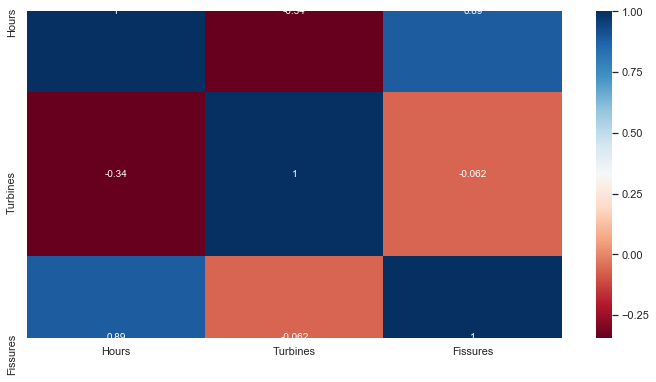

In [8]:
corr = turbines.corr()
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap = 'RdBu', annot = True)

As we expected, there is a important relation between 'Hours' and 'Fissures'. It is quite reasonable to accept that the turbines wheels will wear out more or less, according to their usage time.

There are several linear generalized models, each one must be applied considering the nature of your response variable. Some models are applied for continuos, some fo discrete etc. To identify which model to apply in each situation, you have to know the peculiarities of each model and data.

First of all, let's take a look at the histogram of our response variable 'Fissures':

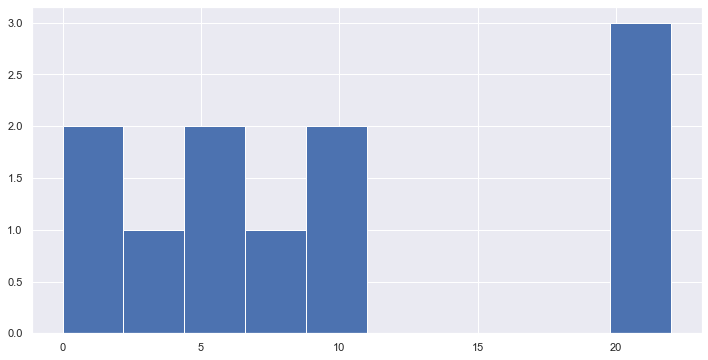

In [9]:
turbines['Fissures'].hist()

We have a discrete asymmetric variable for count data (number of fissures). That is a perfect case for a Poisson Regression Model, as Poisson distribution is the 'ace' distribution for count data. So, let's see how we can do it using statsmodels library.

## Fitting Generalized Linear Models

First of all, we already imported some tools to be used, two of them are the statsmodels normal default API and the statsmodels formula API. We do not need both APIs to fit our model, however we did import both of them to show how we can fit a generalized linear model using the statsmodels default way and the 'formula way' of the R language.

In [10]:
from scipy.stats import chi2

To use statsmodels GLM method, we have to make a simple alteration to the X matrix. To proceed we have to add a constant column to the matrix to represent 'intercept' of the model. It can be done as follows: 

In [11]:
data = turbines.drop('Fissures', axis = 1)
data = sm.add_constant(data)

D:\Python\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Now, we are ready to fit our Poisson model. The GLM method demands our response variable (y=Fissures), our data matrix, the family of distributions (Poisson) and its link function (log for our case).

* **OBS:** Our goal is to show how to fit a GLM in Python. If you are confused by theorical concepts, you should read the theory of generalized linear models in depth.

In [12]:
pois_log = sm.GLM(turbines['Fissures'], data, family = sm.families.Poisson(), link = sm.families.links.log).fit()

Now we can call for the summary() method from our pois_log object to visualize a bunch of useful results of the fitted Poisson model:

In [13]:
print(pois_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Fissures   No. Observations:                   11
Model:                            GLM   Df Residuals:                        8
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24.317
Date:                Thu, 07 Jan 2021   Deviance:                       8.9842
Time:                        12:04:44   Pearson chi2:                     7.89
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5604      0.566     -0.989      0.3

The parameters estimations were -0.5604, 0.0007 and 0.0189 for the intercept, Hours and Turbines respectively. We must also pay attention to Scale and Deviance, this quantities will be useful to decide if the model should be considered or not.

Another import thing to look at is the P-value column for the signifficance test. Considering a signifficance level of 5%, we can see that the intercept is not signifficant to the model, so we should remove it. First let's check the applicability of the model.

We can define a new deviance measure by the quotient between the deviance and the scale of the model, if this value is less than a Chi-square on the 95th percentille with degrees of freedom equal to number of variables of the model, we can go foward with the model.

In [14]:
deviance1 = pois_log.deviance/pois_log.scale
q1 = chi2.ppf(0.95, pois_log.df_resid)
deviance1 < q1

True

Comparing the deviance to the Chi-square we got want we wanted, so we can proceed with our fitted model. In the case that the new deviance is greater than the Chi-square value, you should look for other solutions such as increasing the sample size, incresing the number of variables or try another convenient model.

### Variable Selection

Either you are doing a stastistical approach or a machine learning approach to your data, variable selection is a very important step as you wish to obtain a good but simple model.

In machine learning, the variable selection is part of the process known as 'features engineering' and its main goal is to simplify the complexity of the model seeking the reducing of computational cost. In statistics we are more interested in getting rid of variables with irrelevant contributions seeking simplicity of interpretation  and applicability due theoretical assumptions.

We already that the intercept is not signifficant to the model, so it will be removed and the model will be fitted again without it.

Pay attention to the 'R-style' formula way to fit a GLM using statsmodel. The '-1' stands for the intercept removal.

In [15]:
pois_final = smf.glm('Fissures ~ Hours + Turbines - 1', data = turbines, family = sm.families.Poisson()).fit()

In [16]:
print(pois_final.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Fissures   No. Observations:                   11
Model:                            GLM   Df Residuals:                        9
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24.830
Date:                Thu, 07 Jan 2021   Deviance:                       10.010
Time:                        12:04:47   Pearson chi2:                     8.17
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Hours          0.0006   5.46e-05     11.070      0.0

Both variables are signifficant, so now we have our final model. We can proceed with a residual analysis.

### Residual Analysis

Generalized Linear Models are alternative models to the cases where the residuals are not normally distributed, howerver if you have normality, everything gets brighter and you can have nice properties to work with. So let's check normality for our residues:

In [17]:
fitted = pois_final.fittedvalues
res_deviance = pois_final.resid_deviance

#### Normality

There is a lot of possibilities for checking normality of data, the most common one are the tests Shapiro-Wilks and Lilliefors, and the quantile-quantile plot (QQ-plot). For the residues of our model, we have:

In [18]:
from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import  lilliefors
import pylab

In [19]:
statistic, pvalue = lilliefors(res_deviance)
statistic1, pvalue1 = shapiro(res_deviance)
print("The Lillierfors P-value was: {}".format(pvalue))
print("The Shapiro P-value was: {}".format(pvalue1))

The Lillierfors P-value was: 0.2
The Shapiro P-value was: 0.9354790449142456


Both tests gave p-values greater than 0.05, it means that we can consider the risidues normally distributed and the following QQ-plot supports this affirmation.

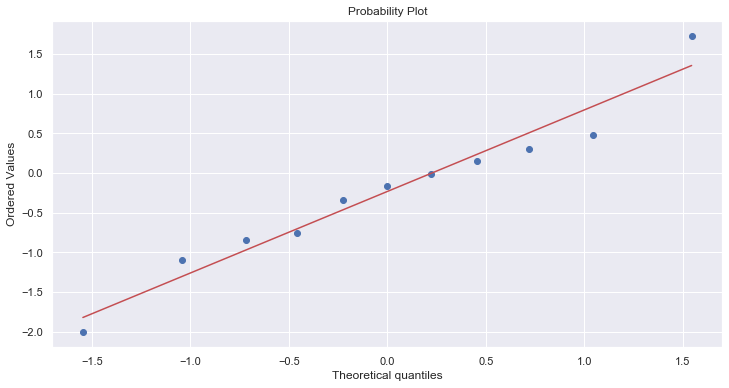

In [20]:
probplot(res_deviance, dist = 'norm', plot = pylab)
pylab.show()

Although we have a very small dataset, we can see that the points are well distributed 'over' the line, which indicates normality.

Now let's investigate the possibility of homocedasticity.

#### Variance Function

To check for homecedasticity we can simply plot the fitted values versus its residues, if the variance is "constant" we expect to see points randomly and symmetrically distributed around zero. For our model, we have:

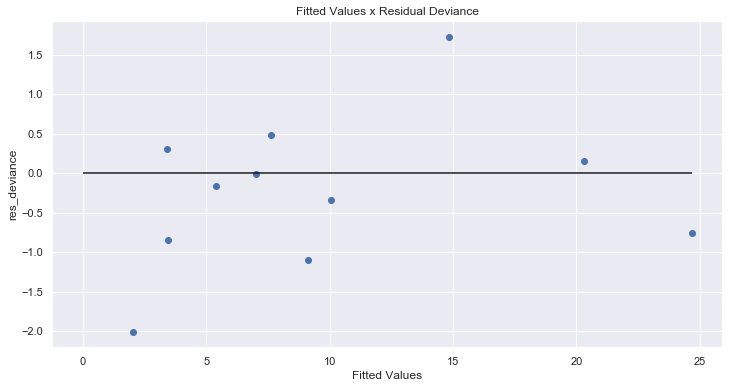

In [21]:
fig, ax = plt.subplots()

ax.set_title('Fitted Values x Residual Deviance')
ax.set_xlabel('Fitted Values')
ax.set_ylabel('res_deviance')
ax.scatter(fitted, res_deviance)
plt.hlines(0, 0, np.max(fitted))

As already said, we would like to have a larger dataset to make more reliable conclusions, however considering the data that we have, the results are good for homocedasticity.

Another thing that we can check to evaluate the model is the link function and it also can be done by visualization.

#### Link Function

We can plot the fiited values by observed values, if the link function used was appropriate we expect to see the points distributed linearly, something like the identity y=x (the fitted values equal to the obeserved values). The following plot shows that log link function was not bad for this case:

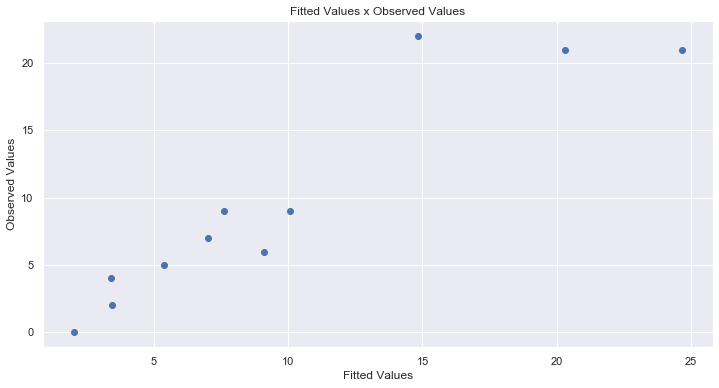

In [22]:
fig, ax = plt.subplots()

ax.set_title('Fitted Values x Observed Values')
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Observed Values')
ax.scatter(fitted, turbines['Fissures'])

#### Independency of the Errors

Usually we talk of non-autocorrelation of the residues, but in the case that we have normality of residues we also have independency for them. We can check if the residues are autocorrelated by doing a Durbin-Watson test or even better, an ACF plot as we can see as follows:

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

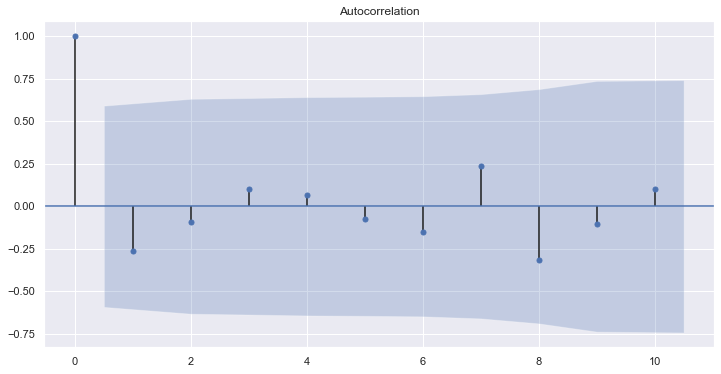

In [24]:
acf = plot_acf(res_deviance)

Looking at the ACF plot, we see a perfect autocorrelation for the first observation but this will always be the case as that result is the correlation between the first observation with itself. Knowing that, we have to start looking at the second observation and so on. All of them (except for the first, of course) are within the confidence boundaries for non-autocorrelation, so we can say the residues are not autocorrelated, even better, they are independent because are normally distributed.

Another important part of building a good generalized linear model is checking for outliers, influential points or leverage points.

### Diagnostic

#### Influential Points

To identify the influential points we can use statsmodels own tools and ask for the Cook's distance for each observation, and then analyze its impact on the model.

Above we can see the obsevations organized from the bigger to the smaller Cook's distance:

In [25]:
infl = pois_final.get_influence(observed = False)
summ_infl = infl.summary_frame()
summ_infl.sort_values('cooks_d', ascending = False)

,dfb_Hours,dfb_Turbines,cooks_d,standard_resid,hat_diag,dffits_internal
8,0.516571,-0.110091,0.375558,2.019124,0.155576,0.866670
10,-0.600651,0.257722,0.328369,-0.963364,0.414396,-0.810394
7,-0.480309,0.361961,0.122123,-1.123840,0.162046,-0.494213
0,0.314030,-0.372933,0.069802,-1.465472,0.061037,-0.373638
2,0.098245,-0.143994,0.011929,-0.790734,0.036754,-0.154459
1,-0.120294,0.148300,0.011167,0.343277,0.159335,0.149448
5,-0.038674,0.102135,0.010523,0.517171,0.072950,0.145076
6,0.020367,-0.076720,0.007469,-0.353722,0.106656,-0.122221
9,0.053749,-0.002271,0.005602,0.180582,0.255704,0.105845
4,0.003618,-0.017206,0.000419,-0.168202,0.028766,-0.028947


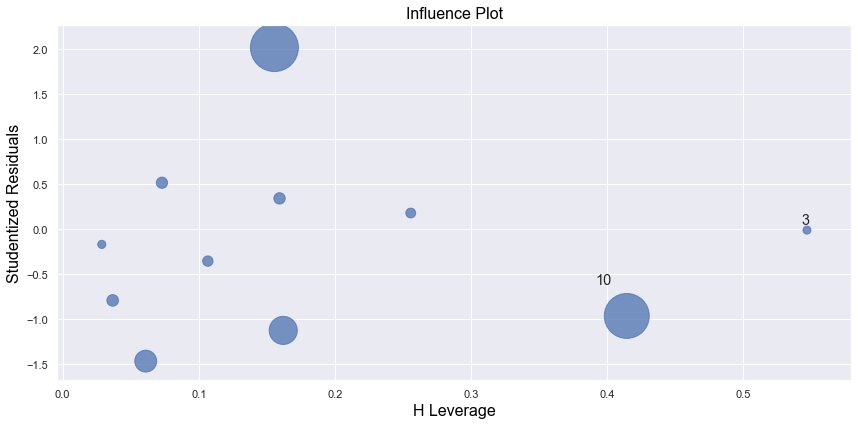

In [26]:
fig = infl.plot_influence(criterion = 'cooks')
fig.tight_layout(pad = 1.0)

The influnce plot is a very good tool to identify the influential points. We can see that some points are big and others are small. The size of the point is related to the residue, that is, the observation number 3 has a small residue but high leverage while the obsevation number 10 has a large residue and is also influential.

#### Leverage Points

The leverage points can be identified by plotting the main diagonal values of the hat matrix and verifying if some of them are above the value of (2p)/n, where 'p' is the number of variables of the model and 'n' is the sample size:

In [27]:
n = turbines.shape[0]
p = len(pois_final.params)

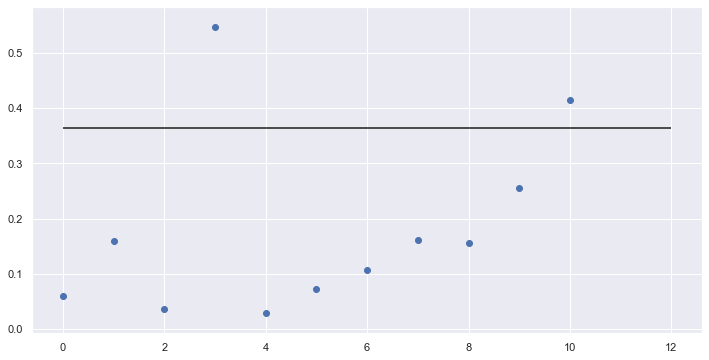

In [28]:
h = pois_final.get_hat_matrix_diag(observed = False)
plt.scatter(range(len(h)), h)
plt.hlines(2*p/n, 0, len(h)+1)

It is easy to see which are the leverage points for this case, but in the case where we have a large dataset, we can see the points by simply doing:

In [29]:
i, = np.where(h>2*p/n)
print(i)

[ 3 10]


A very important thing to keep in mind is the fact that training your model is something you should do to have reliable results to work with. The Holdout and Cross-validation techniques are powerful tools you can use to improve your model. For our case, we could try somenthing like 'Leave one out' (a type cross-validation technique for small datasets) but our dataset is too small even for that. The act of training and predicting on the same observation is a source of bias and you would want to minimize that as much as you can.